# MLT model #1
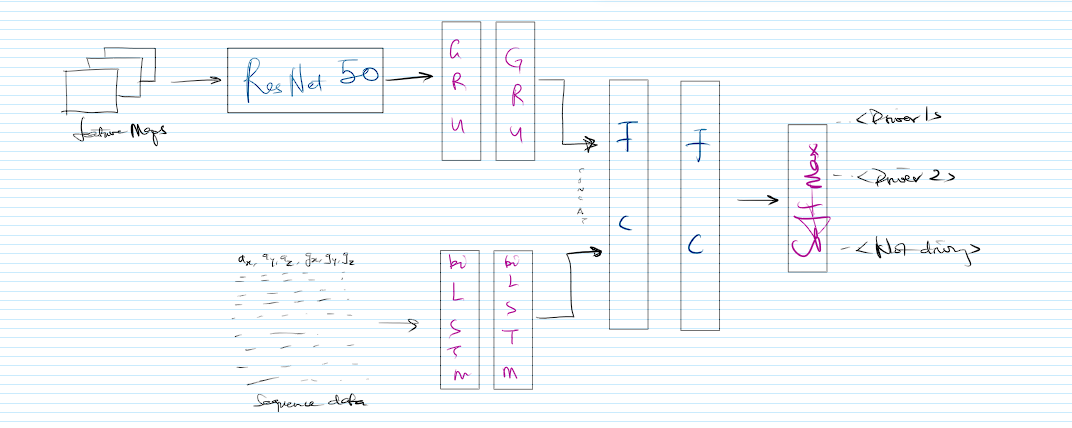


Let's get the feature maps and sequence data in;

In [1]:
import numpy as np
import torch

In [2]:
# feature maps data
X_fmap = np.load('./data/feature_maps_labels/feature_maps.npy')
X_fmap = torch.tensor(X_fmap, dtype=torch.float32)
y_fmap = np.load('./data/feature_maps_labels/labels.npy')
y_fmap = torch.tensor(y_fmap, dtype=torch.float32)

# sequence data for biLSTM
X_seq = np.load('./data/lstm_features_labels/lstm_features.npy')
X_seq = torch.tensor(X_seq, dtype=torch.float32)
y_seq = np.load('./data/lstm_features_labels/lstm_labels.npy')
y_seq = torch.tensor(y_seq, dtype=torch.float32)

# Choose "car" as the positive class while the rest as negative
y_mapped = torch.where(y_seq == 5, torch.tensor(1.), torch.tensor(0.))
y_seq = y_mapped

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split

In [4]:
class TransportModeDataset(Dataset):
      def __init__(self, features, labels):
            self.features = features
            self.labels = labels

      def __len__(self):
            return len(self.features)

      def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]

class FeatureMapDataset(Dataset):
      def __init__(self, feature_maps, labels):
            self.feature_maps = feature_maps
            self.labels = labels

      def __len__(self):
            return len(self.feature_maps)

      def __getitem__(self, idx):
            return self.feature_maps[idx], self.labels[idx]

In [5]:
def create_dataloaders(features, labels, dataset, k=5, batch_size=16, random_seed=42):
      
      kf = KFold(n_splits=k, shuffle=True, random_state=random_seed)
      dataloaders = []

      for train_index, val_index in kf.split(features):
            train_features, val_features = features[train_index], features[val_index]
            train_labels, val_labels = labels[train_index], labels[val_index]

            train_dataset = dataset(train_features, train_labels)
            validation_dataset = dataset(val_features, val_labels)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

            dataloaders.append((train_loader, validation_loader))
      
      return dataloaders

In [6]:
import torch
import torch.nn as nn
from torchvision import models

In [7]:
class BiLSTMNetwork(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers):
            super(BiLSTMNetwork, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

      def forward(self, x):
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            return out[:, -1, :]  # Return the last time step

class ResNet50_GRU(nn.Module):
      def __init__(self, hidden_size, num_layers):
            super(ResNet50_GRU, self).__init__()
            self.resnet50 = models.resnet50(weights='DEFAULT')
            # freeze weights
            for param in self.resnet50.parameters():
                  param.requires_grad = False
            self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
            self.batch_norm = nn.BatchNorm2d(2048)
            self.dropout = nn.Dropout(0.5)
            self.gru = nn.GRU(input_size=7*7, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.5)

      def forward(self, x):
            features = self.resnet50(x)
            features = self.batch_norm(features)
            features = self.dropout(features)
            features = features.view(x.size(0), 2048, 7*7)
            gru_out, _ = self.gru(features)
            return gru_out[:, -1, :]  # Return the last time step

class MultitaskModel(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers):
            super(MultitaskModel, self).__init__()
            self.lstm_network = BiLSTMNetwork(input_size, hidden_size, num_layers)
            self.resnet_gru_network = ResNet50_GRU(hidden_size, num_layers)
            self.fc1 = nn.Linear(hidden_size * 3, hidden_size)  # Adjusted for the concatenated input size
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, 1)  # Output for driver identification (Driver1/Driver2)
            self.sigmoid = nn.Sigmoid()
            self.fc_transport = nn.Linear(hidden_size * 2, 1)  # Output for transport classification (driving/not driving)

      def forward(self, x_lstm, x_resnet):
            lstm_out = self.lstm_network(x_lstm)
            resnet_gru_out = self.resnet_gru_network(x_resnet)
            combined_features = torch.cat((lstm_out, resnet_gru_out), dim=1)

            # Transport classification branch
            transport_out = torch.sigmoid(self.fc_transport(lstm_out))

            # Driver identification branch
            out = self.fc1(combined_features)
            out = self.relu(out)
            driver_out = self.sigmoid(self.fc2(out))
            
            return transport_out, driver_out

In [8]:
import itertools

def train_and_evaluate(model, train_loader_seq, val_loader_seq, train_loader_feat, val_loader_feat, 
                       num_epochs, criterion_transport, criterion_driver, optimizer, device, save_path=None):
      train_loss_history = []
      val_loss_history = []
      train_acc_history = []
      val_acc_history = []

      for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            train_loader_seq_iter = itertools.cycle(train_loader_seq)
            train_loader_feat_iter = itertools.cycle(train_loader_feat)

            for _ in range(max(len(train_loader_seq), len(train_loader_feat))):
                  sequences, sequence_labels = next(train_loader_seq_iter)
                  sequences, sequence_labels = sequences.to(device), sequence_labels.to(device)

                  feature_maps, feature_map_labels = next(train_loader_feat_iter)
                  feature_maps, feature_map_labels = feature_maps.to(device), feature_map_labels.to(device)

                  optimizer.zero_grad()

                  # Forward pass
                  transport_out, driver_out = model(sequences, feature_maps)

                  # Compute losses
                  loss_transport = criterion_transport(transport_out.squeeze(), sequence_labels.float())
                  loss_driver = criterion_driver(driver_out.squeeze(), feature_map_labels.float())

                  total_loss = loss_transport + loss_driver

                  # Backward pass and optimization
                  total_loss.backward()
                  optimizer.step()

                  running_loss += total_loss.item()

                  # Calculate accuracy for transport classification
                  predicted_labels = (transport_out > 0.5).int()
                  correct_train += (predicted_labels == sequence_labels).sum().item()
                  total_train += sequence_labels.size(0)

            train_loss_history.append(running_loss / max(len(train_loader_seq), len(train_loader_feat)))
            train_acc_history.append(correct_train / total_train)

            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                  for (sequences, sequence_labels), (feature_maps, feature_map_labels) in zip(val_loader_seq, val_loader_feat):
                        sequences, sequence_labels = sequences.to(device), sequence_labels.to(device)
                        feature_maps, feature_map_labels = feature_maps.to(device), feature_map_labels.to(device)

                        transport_out, driver_out = model(sequences, feature_maps)

                        loss_transport = criterion_transport(transport_out.squeeze(), sequence_labels.float())
                        loss_driver = criterion_driver(driver_out.squeeze(), feature_map_labels.float())

                        total_loss = loss_transport + loss_driver
                        val_loss += total_loss.item()

                        predicted_labels = (transport_out > 0.5).int()
                        correct_val += (predicted_labels == sequence_labels).sum().item()
                        total_val += sequence_labels.size(0)

            val_loss_history.append(val_loss / len(val_loader_seq))
            val_acc_history.append(correct_val / total_val)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]:.4f}, '
                  f'Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]:.4f}')
            
            # Save checkpoint
            # if save_path:
            #       torch.save({
            #       'epoch': epoch,
            #       'model_state_dict': model.state_dict(),
            #       'optimizer_state_dict': optimizer.state_dict(),
            #       'loss': loss,
            #       }, save_path)

      return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [9]:
def test_model(model, test_loader_seq, test_loader_feat, criterion_transport, criterion_driver, device):
      model.eval()
      test_loss = 0.0
      correct_test = 0
      total_test = 0

      with torch.no_grad():
            for (sequences, sequence_labels), (feature_maps, feature_map_labels) in zip(test_loader_seq, test_loader_feat):
                  sequences, sequence_labels = sequences.to(device), sequence_labels.to(device)
                  feature_maps, feature_map_labels = feature_maps.to(device), feature_map_labels.to(device)

                  transport_out, driver_out = model(sequences, feature_maps)

                  loss_transport = criterion_transport(transport_out.squeeze(), sequence_labels.float())
                  loss_driver = criterion_driver(driver_out.squeeze(), feature_map_labels.float())

                  total_loss = loss_transport + loss_driver
                  test_loss += total_loss.item()

                  predicted_labels = (transport_out > 0.5).int()
                  correct_test += (predicted_labels == sequence_labels).sum().item()
                  total_test += sequence_labels.size(0)

      test_loss /= len(test_loader_seq)
      test_accuracy = correct_test / total_test

      print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

      return test_loss, test_accuracy

Getting the test data first; [No need for this later on as I've already kept test data from the beginning]

In [10]:
# Split data into train/val/test
train_val_idx_FMAPs, test_idx_FMAPs = train_test_split(np.arange(len(y_fmap)), test_size=0.2, random_state=42, stratify=y_fmap)
train_val_idx_SEQs, test_idx_SEQs = train_test_split(np.arange(len(y_seq)), test_size=0.2, random_state=42, stratify=y_seq)

train_val_data_FMAP = (X_fmap[train_val_idx_FMAPs], y_fmap[train_val_idx_FMAPs])
train_val_data_SEQ = (X_seq[train_val_idx_SEQs], y_seq[train_val_idx_SEQs])


# prep test dat
test_data_FMAP = FeatureMapDataset(X_fmap[test_idx_FMAPs], y_fmap[test_idx_FMAPs])
test_data_SEQ = TransportModeDataset(X_seq[test_idx_SEQs], y_seq[test_idx_SEQs])

# Prepare test DataLoader
batch_size = 16
test_loader_fmap = DataLoader(test_data_FMAP, batch_size=batch_size, shuffle=False)
test_loader_seq = DataLoader(test_data_SEQ, batch_size=batch_size, shuffle=False)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
# Parameters
input_size = ...  # Define input size for BiLSTM
hidden_size = ...  # Define hidden size for both LSTM and GRU
num_layers = ...  # Define number of layers for both LSTM and GRU
num_epochs = 10
batch_size = 16
k_folds = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')